In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("/content/card_transdata.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [4]:
print("\nOriginal class distribution:")
print(df['fraud'].value_counts(normalize=True))


Original class distribution:
fraud
0.0    0.912597
1.0    0.087403
Name: proportion, dtype: float64


In [8]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split



In [9]:
X = df.drop('fraud', axis=1)
y = df['fraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

print("\nTrain set distribution (before SMOTE):")
print(y_train.value_counts(normalize=True))
print("\nTest set distribution (untouched realistic):")
print(y_test.value_counts(normalize=True))



Train set distribution (before SMOTE):
fraud
0.0    0.912597
1.0    0.087403
Name: proportion, dtype: float64

Test set distribution (untouched realistic):
fraud
0.0    0.912597
1.0    0.087403
Name: proportion, dtype: float64


In [10]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE (train only):")
print(y_train_res.value_counts(normalize=True))


After SMOTE (train only):
fraud
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


In [13]:
if y_train.value_counts(normalize=True).min() < 0.40:
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print("\nAfter SMOTE - training class distribution:")
    print(y_train.value_counts(normalize=True))
else:
    print("\nTraining set already balanced. Skipping SMOTE.")



After SMOTE - training class distribution:
fraud
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


In [14]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import numpy as np

In [15]:
iso_forest = IsolationForest(contamination=0.01, random_state=42)
y_iso = iso_forest.fit_predict(X_train)

lof = LocalOutlierFactor(n_neighbors=20)
y_lof = lof.fit_predict(X_train)

print("\nIsolation Forest labels (unique):", np.unique(y_iso))
print("LOF labels (unique):", np.unique(y_lof))



Isolation Forest labels (unique): [-1  1]
LOF labels (unique): [-1  1]


In [16]:
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [17]:
model = XGBClassifier(eval_metric='logloss', random_state=42)

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
print("\nCross-validation F1 scores:", cv_scores)
print("Mean CV F1 Score:", cv_scores.mean())

model.fit(X_train, y_train)

y_pred = model.predict(X_test)


Cross-validation F1 scores: [0.99838809 0.99895207 0.99899507 0.99869051 0.99886624]
Mean CV F1 Score: 0.9987783965431927


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Confusion Matrix:
 [[273177    602]
 [    95  26126]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    273779
         1.0       0.98      1.00      0.99     26221

    accuracy                           1.00    300000
   macro avg       0.99      1.00      0.99    300000
weighted avg       1.00      1.00      1.00    300000



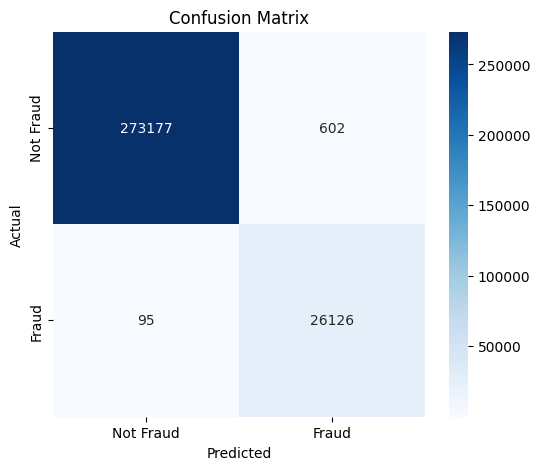

In [20]:
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

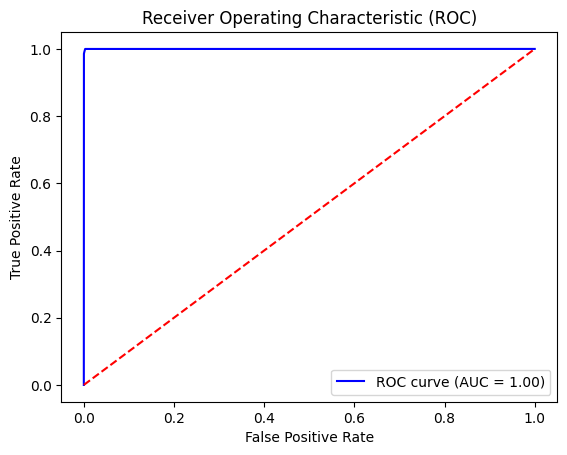

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [22]:
import joblib
joblib.dump(model, "fraud_xgb.pkl")


['fraud_xgb.pkl']